# **Forecasting Quality of Life: The Future of Nations**
A project by
* Cervini Stella
* Simone Mattia
* Montalbano Daniel
* Giuseppe Sabino

### **Packeges import**

---

In [ ]:
pip install pmdarima > /dev/null

In [ ]:
# ----- Loading external modules -----

from google.colab import drive
from shutil import copyfile
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objs as go
from sklearn.decomposition import PCA
import seaborn as sns
from pandas.io.formats.format import get_dataframe_repr_params
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
from matplotlib.ticker import MaxNLocator
import geopandas as gpd
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
import matplotlib.colors as plt_colors

### **Data import**


---



In [ ]:
# ----- Loading the dataset -----


drive.mount('/content/gdrive', force_remount=True)

for file_name in ["FIW_2003-2023.xlsx", "population-dataset.csv", "gdp-dataset.csv", "index_worldbank.csv","political-stability.csv"]:
  if os.path.exists(f'{file_name}/'):
    print(f'{file_name} already loaded')
  else:
    if os.path.exists(f'gdrive/MyDrive/DataScience/{file_name}'):
      # Copy from GDrive to Colab VM
      copyfile(f'gdrive/MyDrive/DataScience/{file_name}', f'{file_name}')
      print(f'File {file_name} loaded')
    else:
      print(f'[!] {file_name} not present in Gdrive')

# Load datasets
df_freedom = pd.read_excel("FIW_2003-2023.xlsx", sheet_name="FIW06-23")
df_population = pd.read_csv("population-dataset.csv", skiprows=[0,1,2,3], index_col="Country Name")
df_gdp = pd.read_csv("gdp-dataset.csv", skiprows=[0,1,2,3], index_col="Country Name")
df_stability = pd.read_csv("political-stability.csv", skiprows=[0,1,2,3], index_col="Country Name")
df_index = pd.read_csv('index_worldbank.csv')

Mounted at /content/gdrive
File FIW_2003-2023.xlsx loaded
File population-dataset.csv loaded
File gdp-dataset.csv loaded
File index_worldbank.csv loaded
File political-stability.csv loaded


### **Data Integration**

---

In [ ]:
# ----- Data integration -----

# Fix error in world bank datasets
for df in [df_population, df_gdp, df_stability]:
  df.rename(index={'Bahamas, The':'Bahamas'},inplace=True)
  df.rename(index={'Brunei Darussalam':'Brunei'},inplace=True)
  df.rename(index={'Congo, Rep.':'Congo (Brazzaville)'},inplace=True)
  df.rename(index={'Congo, Dem. Rep.':'Congo (Kinshasa)'},inplace=True)
  df.rename(index={'Czechia':'Czech Republic'},inplace=True)
  df.rename(index={'Egypt, Arab Rep.':'Egypt'},inplace=True)
  df.rename(index={'Iran, Islamic Rep.':'Iran'},inplace=True)
  df.rename(index={'Kyrgyz Republic':'Kyrgyzstan'},inplace=True)
  df.rename(index={'Lao PDR':'Laos'},inplace=True)
  df.rename(index={'Micronesia, Fed. Sts.':'Micronesia'},inplace=True)
  df.rename(index={'Korea, Dem. People\'s Rep.':'North Korea'},inplace=True)
  df.rename(index={'Russian Federation':'Russia'},inplace=True)
  df.rename(index={'Slovak Republic':'Slovakia'},inplace=True)
  df.rename(index={'Korea, Rep.':'South Korea'},inplace=True)
  df.rename(index={'Syrian Arab Republic':'Syria'},inplace=True)
  df.rename(index={'Gambia, The':'The Gambia'},inplace=True)
  df.rename(index={'Hong Kong SAR, China, The':'Hong Kong'},inplace=True)
  df.rename(index={'Venezuela, RB, The':'Venezuela'},inplace=True)
  df.rename(index={'Yemen, Rep.':'Yemen'},inplace=True)
  df.rename(index={'Turkiye':'Turkey'},inplace=True)

series_names = [
    "Access to electricity (% of population)",
    "Birth rate, crude (per 1,000 people)",
    "Death rate, crude (per 1,000 people)",
    "Gini index","Life expectancy at birth, total (years)",
    "Mortality rate, infant (per 1,000 live births)",
    "Unemployment, total (% of total labor force) (national estimate)"
]


# Index dataset parsing
dfs = []
for series_name in series_names:
    filtered_df = df_index[df_index["Series Name"] == series_name]
    id_vars = ["Country Name", "Country Code", "Series Name", "Series Code"]
    value_vars = filtered_df.columns[4:]

    new_df = pd.melt(filtered_df, id_vars=id_vars, value_vars=value_vars, var_name="Edition", value_name=series_name)

    # Remove the brackets and extract the year from the "Year" column
    new_df["Edition"] = new_df["Edition"].str.extract(r'(\d{4})')[0].astype(int)

    dfs.append(new_df)

# Merge the DataFrames on "Country Name" and "Year"
df_index_new = dfs[0]  # Start with the first DataFrame
for i in range(1, len(dfs)):
    df_index_new = pd.merge(df_index_new, dfs[i], on=["Country Name", "Country Code", "Edition"])

df_index_new.drop(columns=['Series Name_x', 'Series Code_x', 'Series Name_y', 'Series Code_y','Series Code','Country Name','Series Name'], inplace=True)
for col in series_names:
  df_index_new.replace('..', np.nan, inplace=True)
  df_index_new[col] =pd.to_numeric(df_index_new[col])

# Population and country code integration
population = []
country_code = []
gdp = []
stability = []
error_nations = []

for index, row in df_freedom.iterrows():
    try:
        if "Cyprus" in row["Country/Territory"]:
            # Cyprus and Northern Cyprus are merged in the population dataset
            population.append(df_population.loc["Cyprus"][str(row["Edition"])] / 2)
            country_code.append(df_population.loc["Cyprus"]["Country Code"])
            gdp.append(df_gdp.loc["Cyprus"][str(row["Edition"])])
            stability.append(df_stability.loc["Cyprus"][str(row["Edition"])])
        elif row["Country/Territory"] in ["Gaza Strip", "West Bank"]:
            # Gaza Strip and West Bank are merged in the population dataset
            population.append(df_population.loc["West Bank and Gaza"][str(row["Edition"])]/2)
            country_code.append(df_population.loc["West Bank and Gaza"]["Country Code"])
            gdp.append(df_gdp.loc["West Bank and Gaza"][str(row["Edition"])])
            stability.append(df_stability.loc["West Bank and Gaza"][str(row["Edition"])])
        else:
            # Extract the population in that Country/Territory in that year
            population.append(df_population.loc[row["Country/Territory"]][str(row["Edition"])])
            country_code.append(df_population.loc[row["Country/Territory"]]["Country Code"])
            gdp.append(df_gdp.loc[row["Country/Territory"]][str(row["Edition"])])
            stability.append(df_stability.loc[row["Country/Territory"]][str(row["Edition"])])
    except:
        # Handle the case when the "Country/Territory" value is empty or not found
        error_nations.append(row["Country/Territory"])
        population.append(None)
        country_code.append(None)
        gdp.append(None)
        stability.append(None)

df_freedom["Population"] = population
df_freedom["Country Code"] = country_code
df_freedom["GDP"] = gdp
df_freedom["Political Stability"] = stability
df_freedom = pd.merge(df_freedom, df_index_new, on=["Country Code","Edition"])

display(df_freedom)

<ipython-input-6-d7656eb68364>:53: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Series Code_x', 'Series Name_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_index_new = pd.merge(df_index_new, dfs[i], on=["Country Name", "Country Code", "Edition"])
<ipython-input-6-d7656eb68364>:53: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Series Code_x', 'Series Name_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_index_new = pd.merge(df_index_new, dfs[i], on=["Country Name", "Country Code", "Edition"])


,Country/Territory,Region,C/T?,Edition,Status,PR Rating,CL Rating,A,B,C,...,Country Code,GDP,Political Stability,Access to electricity (% of population),"Birth rate, crude (per 1,000 people)","Death rate, crude (per 1,000 people)",Gini index,"Life expectancy at birth, total (years)","Mortality rate, infant (per 1,000 live births)","Unemployment, total (% of total labor force) (national estimate)"
0,Afghanistan,Asia,c,2022,NF,7,6,0,0,1,...,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Albania,Europe,c,2022,PF,3,3,9,12,7,...,ALB,18551.716479,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Algeria,Africa,c,2022,NF,6,5,3,4,3,...,DZA,13209.596769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Andorra,Europe,c,2022,F,1,1,12,15,11,...,AND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,Africa,c,2022,NF,6,5,3,5,2,...,AGO,6973.696299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3320,Vanuatu,Asia,c,2006,F,2,2,9,15,8,...,VUT,2417.246832,1.349654,26.440000,31.850,5.793,NaN,69.462,23.7,8.01
3321,Vietnam,Asia,c,2006,NF,7,5,0,1,1,...,VNM,4146.951612,0.405120,96.000000,16.995,5.927,35.8,73.319,19.6,NaN
3322,Yemen,Middle East,c,2006,PF,5,5,4,6,3,...,YEM,NaN,-1.345312,55.800335,37.776,6.208,NaN,65.988,52.4,15.70
3323,Zambia,Africa,c,2006,PF,4,4,5,11,6,...,ZMB,2409.243466,0.363792,24.082327,44.014,11.933,54.6,51.795,58.8,NaN


### **Feature selection**

---

In [ ]:
# Feature Selection

df_freedom_all_feature = df_freedom.copy()

df_freedom = df_freedom.rename(columns = {'Birth rate, crude (per 1,000 people)' : 'Birth rate', 'Life expectancy at birth, total (years)' : 'Life expectancy'})

print(df_freedom.columns)

feature_selection = [
       'Country/Territory',
       'Region', 'Edition', 'Status', 'Total', 'Population', 'Country Code', 'GDP',
       'Political Stability',
       #'Access to electricity (% of population)',
       'Birth rate',
       #'Death rate, crude (per 1,000 people)',
       'Life expectancy',
       #'Mortality rate, infant (per 1,000 live births)'
       ]

df_freedom = df_freedom[feature_selection]

df_freedom

Index(['Country/Territory', 'Region', 'C/T?', 'Edition', 'Status', 'PR Rating',
       'CL Rating', 'A', 'B', 'C', 'Add Q', 'Add A', 'PR', 'D', 'E', 'F', 'G',
       'CL', 'Total', 'Population', 'Country Code', 'GDP',
       'Political Stability', 'Access to electricity (% of population)',
       'Birth rate', 'Death rate, crude (per 1,000 people)', 'Gini index',
       'Life expectancy', 'Mortality rate, infant (per 1,000 live births)',
       'Unemployment, total (% of total labor force) (national estimate)'],
      dtype='object')


,Country/Territory,Region,Edition,Status,Total,Population,Country Code,GDP,Political Stability,Birth rate,Life expectancy
0,Afghanistan,Asia,2022,NF,10,41128771.0,AFG,NaN,NaN,NaN,NaN
1,Albania,Europe,2022,PF,67,2775634.0,ALB,18551.716479,NaN,NaN,NaN
2,Algeria,Africa,2022,NF,32,44903225.0,DZA,13209.596769,NaN,NaN,NaN
3,Andorra,Europe,2022,F,93,79824.0,AND,NaN,NaN,NaN,NaN
4,Angola,Africa,2022,NF,30,35588987.0,AGO,6973.696299,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3320,Vanuatu,Asia,2006,F,80,222923.0,VUT,2417.246832,1.349654,31.850,69.462
3321,Vietnam,Asia,2006,NF,19,83951800.0,VNM,4146.951612,0.405120,16.995,73.319
3322,Yemen,Middle East,2006,PF,31,21966298.0,YEM,NaN,-1.345312,37.776,65.988
3323,Zambia,Africa,2006,PF,56,11971567.0,ZMB,2409.243466,0.363792,44.014,51.795


### **Data quality**


---

In [ ]:
# ----- Data Quality -----

for c in feature_selection:
  print(f"{c} = {df_freedom[c].isna().sum()}")
print()

# Remove Nan rows
print(df_freedom.shape)
df_freedom = df_freedom.dropna()
print(df_freedom.shape)

# Check the presence for each year
test_df = df_freedom.groupby("Country/Territory").count()["Total"]
test_df = test_df[test_df < 15] # Missing 2022 data for some variebles
print("\n",test_df)

Country/Territory = 0
Region = 0
Edition = 0
Status = 0
Total = 0
Population = 0
Country Code = 0
GDP = 168
Political Stability = 198
Birth rate = 216
Life expectancy = 260

(3325, 11)
(2945, 11)

 Country/Territory
Djibouti         9
Gaza Strip      11
Kosovo          14
Puerto Rico     11
Somalia          9
South Sudan      4
Turkmenistan    14
West Bank       11
Name: Total, dtype: int64


### **Life index creation**


---


In [ ]:
# ----- Normalization and Life Index -----

min_max_scaler_gdp = MinMaxScaler()
df_freedom['GDP_norm'] = min_max_scaler_gdp.fit_transform(df_freedom[['GDP']])
df_freedom['Total'] = df_freedom['Total']/100
min_max_scaler_pol = MinMaxScaler()
df_freedom['Political_stability_norm'] = min_max_scaler_pol.fit_transform(df_freedom[['Political Stability']])
min_max_scaler_birth = MinMaxScaler()
df_freedom['Birth_rate_norm'] = min_max_scaler_birth.fit_transform(df_freedom[['Birth rate']])
min_max_scaler_life = MinMaxScaler()
df_freedom['Life_expentancy_norm'] = min_max_scaler_life.fit_transform(df_freedom[['Life expectancy']])

df_freedom['Life Index'] = (df_freedom['GDP_norm'] + df_freedom['Total'] + df_freedom['Political_stability_norm'] + df_freedom['Birth_rate_norm'] + df_freedom['Life_expentancy_norm'])/5

df_freedom

<ipython-input-9-ff9fb8aed3b5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_freedom['GDP_norm'] = min_max_scaler_gdp.fit_transform(df_freedom[['GDP']])
<ipython-input-9-ff9fb8aed3b5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_freedom['Total'] = df_freedom['Total']/100
<ipython-input-9-ff9fb8aed3b5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

,Country/Territory,Region,Edition,Status,Total,Population,Country Code,GDP,Political Stability,Birth rate,Life expectancy,GDP_norm,Political_stability_norm,Birth_rate_norm,Life_expentancy_norm,Life Index
196,Afghanistan,Asia,2021,NF,0.27,40099462.0,AFG,1673.964059,-2.529855,35.842,61.982,0.007038,0.066405,0.683216,0.457859,0.296904
197,Albania,Europe,2021,PF,0.66,2811666.0,ALB,15532.706056,0.109446,10.240,76.463,0.092223,0.657421,0.114232,0.805576,0.465890
198,Algeria,Africa,2021,NF,0.32,44177969.0,DZA,12170.193777,-0.876465,21.524,76.377,0.071555,0.436647,0.365010,0.803511,0.399345
200,Angola,Africa,2021,NF,0.31,34503774.0,AGO,6523.463613,-0.710836,38.809,61.643,0.036847,0.473736,0.749155,0.449719,0.403891
201,Antigua and Barbuda,Americas,2021,F,0.85,93219.0,ATG,21958.688709,0.955552,12.115,78.497,0.131721,0.846889,0.155903,0.854416,0.567786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3319,Uzbekistan,Eurasia,2006,NF,0.03,26488250.0,UZB,3987.066407,-1.784660,21.000,67.891,0.021256,0.233276,0.353365,0.599745,0.247529
3320,Vanuatu,Asia,2006,F,0.80,222923.0,VUT,2417.246832,1.349654,31.850,69.462,0.011607,0.935140,0.594497,0.637468,0.595742
3321,Vietnam,Asia,2006,NF,0.19,83951800.0,VNM,4146.951612,0.405120,16.995,73.319,0.022239,0.723631,0.264357,0.730082,0.386062
3323,Zambia,Africa,2006,PF,0.56,11971567.0,ZMB,2409.243466,0.363792,44.014,51.795,0.011558,0.714377,0.864832,0.213250,0.472803


<ipython-input-10-145c6b8b6fdd>:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


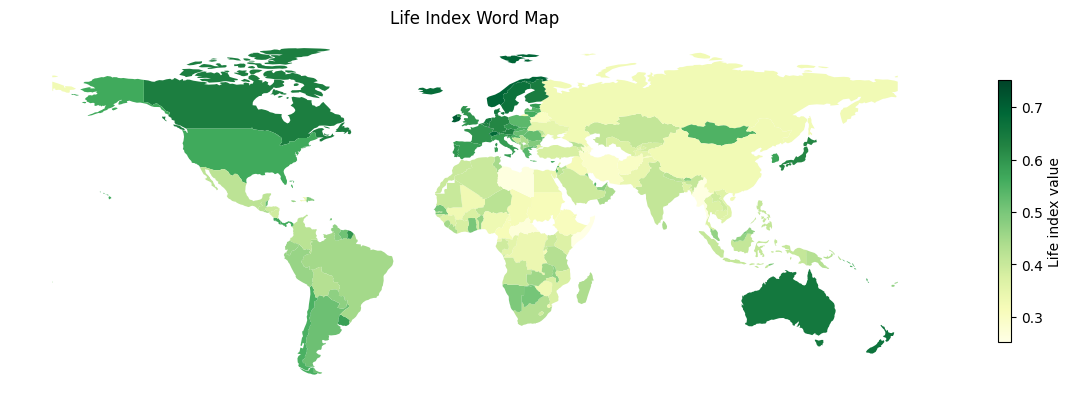

In [ ]:
df = df_freedom[df_freedom["Edition"] == 2021][["Region", "Country Code", "Life Index"]]
df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
df_world = df_world.merge(df, how="left", left_on=['iso_a3'], right_on=['Country Code'])
df_world.plot(column="Life Index", cmap='YlGn', legend=True, legend_kwds={"label": "Life index value", "orientation": "vertical", 'shrink': 0.2}, figsize=(15, 17))
plt.title('Life Index Word Map')
plt.axis('off')
plt.show()

### **Exploratory analysis**


---



In [ ]:
df_freedom.loc[:,['Total',	'Population',	'GDP',	'Political Stability',	'Birth rate',	'Life expectancy', 'Life Index']].describe()

,Total,Population,GDP,Political Stability,Birth rate,Life expectancy,Life Index
count,2945.000000,2.945000e+03,2945.000000,2945.000000,2945.000000,2945.000000,2945.000000
mean,0.615341,3.860036e+07,18476.663436,-0.069511,21.639045,70.795916,0.476014
std,0.281556,1.429661e+08,20384.519031,0.948938,10.618244,8.297434,0.100048
min,0.010000,1.003000e+04,528.871700,-2.826402,5.100000,42.914000,0.218262
25%,0.370000,2.012647e+06,4073.926085,-0.670838,12.000000,64.815000,0.398794
50%,0.640000,7.583269e+06,11435.268434,0.010891,19.334000,72.457220,0.470985
75%,0.890000,2.702694e+07,26625.061810,0.741739,29.686000,77.038000,0.556410
max,1.000000,1.412360e+09,163219.491990,1.639301,50.096000,84.560000,0.750935


In [ ]:
# ----- Trends -----

nation_trends = {}

for nation in df_freedom["Country/Territory"].unique():
    # Filter rows for the current nation
    nation_rows = df_freedom[df_freedom["Country/Territory"] == nation]

    yearly_totals = nation_rows.groupby("Edition")["Total"].sum()
    percentage_change = (yearly_totals.iloc[-1] - yearly_totals.iloc[0]) / yearly_totals.iloc[0]

    # Check if the overall percentage change exceeds the threshold 1%
    if percentage_change >= 0.01:
        nation_trends[nation] = -1
    elif percentage_change <= -0.01:
        nation_trends[nation] = 1
    else:
        nation_trends[nation] = 0

# Create a new column "Trend" in df_freedom and map the trends for each nation
df_freedom["Trend"] = df_freedom["Country/Territory"].map(nation_trends)
df_freedom

<ipython-input-12-cdc928dd4026>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_freedom["Trend"] = df_freedom["Country/Territory"].map(nation_trends)


,Country/Territory,Region,Edition,Status,Total,Population,Country Code,GDP,Political Stability,Birth rate,Life expectancy,GDP_norm,Political_stability_norm,Birth_rate_norm,Life_expentancy_norm,Life Index,Trend
196,Afghanistan,Asia,2021,NF,0.27,40099462.0,AFG,1673.964059,-2.529855,35.842,61.982,0.007038,0.066405,0.683216,0.457859,0.296904,1
197,Albania,Europe,2021,PF,0.66,2811666.0,ALB,15532.706056,0.109446,10.240,76.463,0.092223,0.657421,0.114232,0.805576,0.465890,-1
198,Algeria,Africa,2021,NF,0.32,44177969.0,DZA,12170.193777,-0.876465,21.524,76.377,0.071555,0.436647,0.365010,0.803511,0.399345,1
200,Angola,Africa,2021,NF,0.31,34503774.0,AGO,6523.463613,-0.710836,38.809,61.643,0.036847,0.473736,0.749155,0.449719,0.403891,-1
201,Antigua and Barbuda,Americas,2021,F,0.85,93219.0,ATG,21958.688709,0.955552,12.115,78.497,0.131721,0.846889,0.155903,0.854416,0.567786,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3319,Uzbekistan,Eurasia,2006,NF,0.03,26488250.0,UZB,3987.066407,-1.784660,21.000,67.891,0.021256,0.233276,0.353365,0.599745,0.247529,-1
3320,Vanuatu,Asia,2006,F,0.80,222923.0,VUT,2417.246832,1.349654,31.850,69.462,0.011607,0.935140,0.594497,0.637468,0.595742,-1
3321,Vietnam,Asia,2006,NF,0.19,83951800.0,VNM,4146.951612,0.405120,16.995,73.319,0.022239,0.723631,0.264357,0.730082,0.386062,0
3323,Zambia,Africa,2006,PF,0.56,11971567.0,ZMB,2409.243466,0.363792,44.014,51.795,0.011558,0.714377,0.864832,0.213250,0.472803,1


Total    Population        GDP  Life Index  \
Region      Edition                                               
World       2006     0.551  6.463309e+09  11009.598       0.417   
            2007     0.548  6.550544e+09  11772.385       0.417   
            2008     0.542  6.633037e+09  12316.386       0.418   
            2009     0.543  6.714612e+09  12272.177       0.417   
            2010     0.542  6.795971e+09  12920.156       0.416   
...                    ...           ...        ...         ...   
Middle East 2017     0.229  2.097157e+08  24845.324       0.384   
            2018     0.233  2.134016e+08  25252.631       0.374   
            2019     0.235  2.167319e+08  25369.203       0.364   
            2020     0.228  2.188833e+08  24558.669       0.353   
            2021     0.220  2.207230e+08  26386.888       0.352   

                     Political Stability  Birth rate  Life expectancy  
Region      Edition                                                    
World       2006                  -0.642      20.366           69.552  
            2007                  -0.664      20.314           69.821  
            2008                  -0.649      20.247           69.998  
            2009                  -0.696      20.070           70.396  
            2010                  -0.734      19.917           70.670  
...                                  ...         ...              ...  
Middle East 2017                  -1.014      20.625           75.806  
            2018                  -1.216      19.846           76.137  
            2019                  -1.363      18.797           76.133  
            2020                  -1.348      18.313           74.665  
            2021                  -1.300      17.867           74.458  

[112 rows x 7 columns]

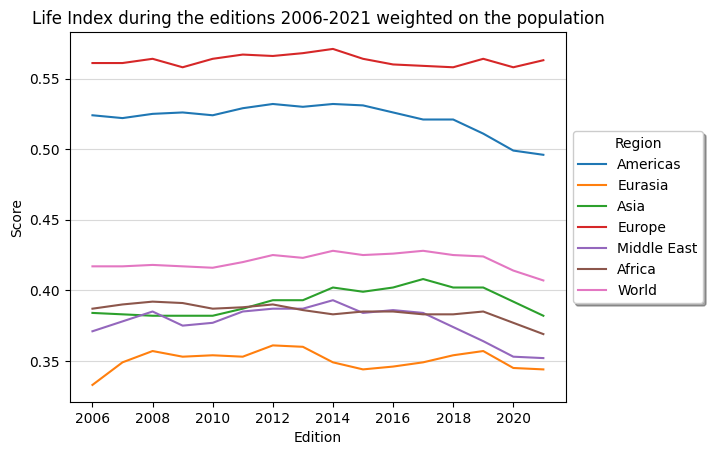

In [ ]:
# ----- World and Region Aggregation -----

# Extract all Country/Territory that have population data and select a column subset
df = df_freedom[df_freedom["Population"].notna()][["Country/Territory", "Region", "Edition", "Total", "Population", "GDP", "Life Index", "Political Stability", "Birth rate", "Life expectancy"]]
regions = list(set(df_freedom["Region"]))

# Calculate the Weighted mean:
for column in ["Total", "GDP", "Life Index", "Political Stability", "Birth rate", "Life expectancy"]:
  df[column] *= df["Population"]
df_world = df.groupby(["Edition"]).sum(numeric_only=True)
df_regions = df.groupby(["Region", "Edition"]).sum(numeric_only=True)
for column in ["Total", "GDP", "Life Index", "Political Stability", "Birth rate", "Life expectancy"]:
  df_regions[column] =  round(df_regions[column] / df_regions["Population"], 3)
  df_world[column] =  round(df_world[column] / df_world["Population"], 3)

# Concat the two dataframe
df_world["Region"] = "World"
df_world = df_world.reset_index().set_index(['Region','Edition'])
df_freedom_aggregation = pd.concat([df_world, df_regions])
display(df_freedom_aggregation)

# Plot data
for index in regions+["World"]:
  df_freedom_aggregation.loc[index]["Life Index"].plot()
plt.title('Life Index during the editions 2006-2021 weighted on the population')
plt.xlabel('Edition')
plt.ylabel('Score')
plt.legend(regions+["World"], loc='upper left', title='Region', bbox_to_anchor=(1, 0.75), ncol=1, fancybox=True, shadow=True)
plt.grid(axis='y', color='0.85')


In [ ]:
df_freedom_aggregation

Total    Population        GDP  Life Index  \
Region      Edition                                               
World       2006     0.551  6.463309e+09  11009.598       0.417   
            2007     0.548  6.550544e+09  11772.385       0.417   
            2008     0.542  6.633037e+09  12316.386       0.418   
            2009     0.543  6.714612e+09  12272.177       0.417   
            2010     0.542  6.795971e+09  12920.156       0.416   
...                    ...           ...        ...         ...   
Middle East 2017     0.229  2.097157e+08  24845.324       0.384   
            2018     0.233  2.134016e+08  25252.631       0.374   
            2019     0.235  2.167319e+08  25369.203       0.364   
            2020     0.228  2.188833e+08  24558.669       0.353   
            2021     0.220  2.207230e+08  26386.888       0.352   

                     Political Stability  Birth rate  Life expectancy  
Region      Edition                                                    
World       2006                  -0.642      20.366           69.552  
            2007                  -0.664      20.314           69.821  
            2008                  -0.649      20.247           69.998  
            2009                  -0.696      20.070           70.396  
            2010                  -0.734      19.917           70.670  
...                                  ...         ...              ...  
Middle East 2017                  -1.014      20.625           75.806  
            2018                  -1.216      19.846           76.137  
            2019                  -1.363      18.797           76.133  
            2020                  -1.348      18.313           74.665  
            2021                  -1.300      17.867           74.458  

[112 rows x 7 columns]

[Text(0.5, 1.0, 'Correlation matrix')]

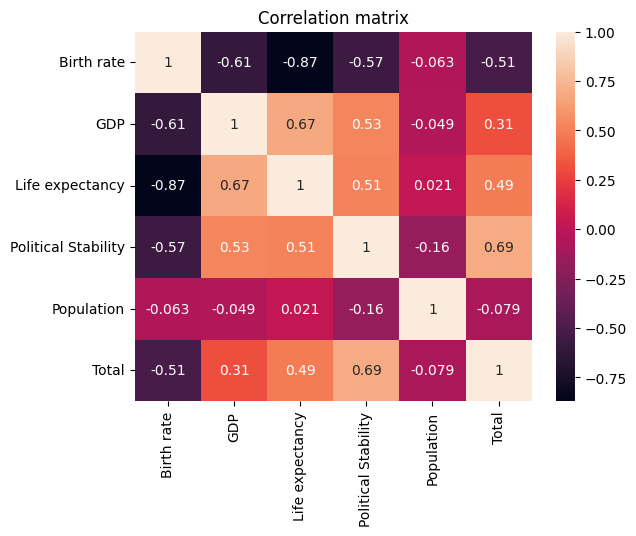

In [ ]:
# ----- Correlations -----

df = df_freedom.dropna().groupby(["Country/Territory", "Region"])[feature_selection].mean(numeric_only=True).reset_index()
heatmap = sns.heatmap(df[df.columns.difference(['Edition', 'Trend'])].corr(numeric_only = True), annot = True)
heatmap.set(title = "Correlation matrix")

In [ ]:
# ----- Status Aggregation -----

# Extract all Country/Territory that have population data and select a column subset
df = df_freedom[df_freedom["Status"].notna()][["Country/Territory", "Region", "Edition", "Status", "Total", "Population", "GDP", "Life Index", "Political Stability", "Birth rate", "Life expectancy"]]
status = list(set(df_freedom["Status"]))

# Calculate the Weighted mean:
for column in ["Total", "GDP", "Life Index", "Political Stability", "Birth rate", "Life expectancy"]:
  df[column] *= df["Population"]
df= df.groupby(["Status", "Edition"]).sum(numeric_only=True)
for column in ["Total", "GDP", "Life Index", "Political Stability", "Birth rate", "Life expectancy"]:
  df[column] =  round(df[column] / df["Population"], 3)
df_freedom_status_aggregation = df

display(df_freedom_status_aggregation)


Total    Population        GDP  Life Index  \
Status Edition                                               
F      2006     0.816  3.033329e+09  16083.979       0.489   
       2007     0.814  3.074408e+09  16923.543       0.488   
       2008     0.815  3.107235e+09  17412.965       0.491   
       2009     0.813  3.127119e+09  17134.193       0.486   
       2010     0.811  3.156759e+09  17856.135       0.488   
       2011     0.817  3.026694e+09  18789.769       0.491   
       2012     0.821  3.056435e+09  19319.684       0.494   
       2013     0.816  3.091964e+09  19909.920       0.495   
       2014     0.836  2.858305e+09  21329.389       0.506   
       2015     0.841  2.896133e+09  21750.375       0.509   
       2016     0.833  2.908965e+09  22473.143       0.506   
       2017     0.829  2.931169e+09  23349.410       0.509   
       2018     0.824  2.957090e+09  24335.476       0.504   
       2019     0.812  2.963633e+09  25199.145       0.505   
       2020     0.793  2.951310e+09  24553.557       0.493   
       2021     0.861  1.524982e+09  44780.133       0.559   
NF     2006     0.209  2.352384e+09   7088.230       0.330   
       2007     0.212  2.411209e+09   8119.566       0.334   
       2008     0.205  2.365485e+09   8813.608       0.336   
       2009     0.188  2.231349e+09   9507.255       0.339   
       2010     0.191  2.267728e+09  10301.382       0.336   
       2011     0.189  2.371299e+09  10866.783       0.342   
       2012     0.187  2.401663e+09  11534.392       0.350   
       2013     0.188  2.342894e+09  11993.595       0.349   
       2014     0.192  2.454984e+09  12307.016       0.352   
       2015     0.195  2.608097e+09  12052.043       0.348   
       2016     0.188  2.613901e+09  12442.198       0.353   
       2017     0.174  2.582894e+09  13275.929       0.357   
       2018     0.172  2.665459e+09  14773.784       0.353   
       2019     0.159  2.726057e+09  15345.146       0.352   
       2020     0.157  2.722119e+09  15231.103       0.340   
       2021     0.156  2.871465e+09  16684.772       0.334   
PF     2006     0.551  1.077596e+09   5286.018       0.403   
       2007     0.542  1.064926e+09   5171.882       0.400   
       2008     0.502  1.160317e+09   5809.117       0.391   
       2009     0.503  1.356144e+09   5610.202       0.385   
       2010     0.502  1.371484e+09   5889.066       0.385   
       2011     0.539  1.483198e+09   7420.932       0.400   
       2012     0.541  1.519244e+09   7778.354       0.402   
       2013     0.519  1.643798e+09   8327.927       0.396   
       2014     0.540  1.853620e+09   8637.725       0.406   
       2015     0.537  1.749443e+09   8603.794       0.402   
       2016     0.544  1.805617e+09   8877.939       0.403   
       2017     0.530  1.896690e+09   9084.344       0.399   
       2018     0.526  1.871524e+09   8548.937       0.400   
       2019     0.517  1.884317e+09   9106.526       0.399   
       2020     0.505  1.971294e+09   9058.982       0.398   
       2021     0.576  3.314323e+09   8672.555       0.400   

                Political Stability  Birth rate  Life expectancy  
Status Edition                                                    
F      2006                  -0.327      18.428           71.115  
       2007                  -0.370      18.242           71.380  
       2008                  -0.340      18.076           71.612  
       2009                  -0.423      17.726           71.954  
       2010                  -0.399      17.444           72.244  
       2011                  -0.383      17.174           72.530  
       2012                  -0.357      16.901           72.828  
       2013                  -0.331      16.518           73.185  
       2014                  -0.219      15.826           74.001  
       2015                  -0.213      15.660           74.210  
       2016                  -0.263      15.400           74.533  
       2017                  -0.188      15.

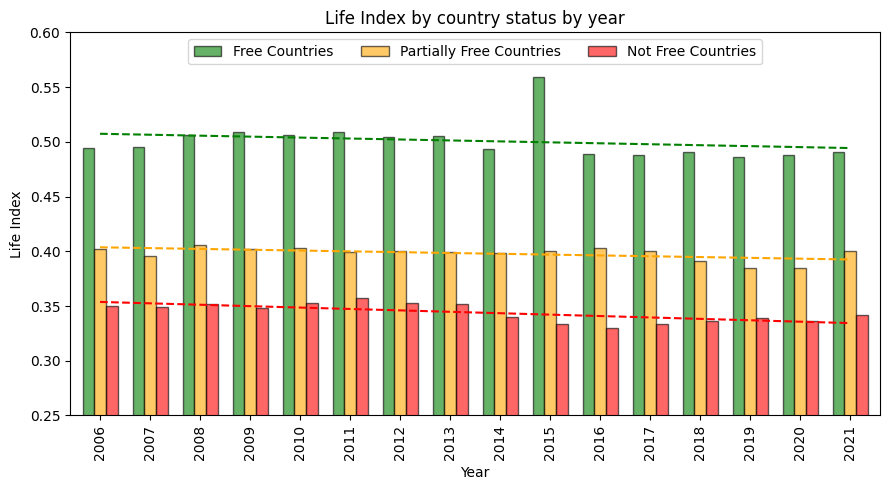

In [ ]:
# ----- Status Plot -----

df = df_freedom_status_aggregation.reset_index()
data = {
    'FIW Survey Edition*': list(set(df_freedom["Edition"])),
    'Free Countries': df[df["Status"] == "F"]["Life Index"].to_list(),
    'Partially Free Countries': df[df["Status"] == "PF"]["Life Index"].to_list(),
    'Not Free Countries': df[df["Status"] == "NF"]["Life Index"].to_list()
}

df = pd.DataFrame(data)

# Set the FIW Survey Edition* column as the index
df.set_index('FIW Survey Edition*', inplace=True)
df = df.sort_index()

# Set custom colors for the bars
colors = ['green', 'orange', 'red']

# Plot the grouped bar chart
ax = df.plot(kind='bar', figsize=(9, 5), width=0.7, color=colors, alpha=0.6, edgecolor='black')
#ax.grid(axis='x', color='0.80')
ax.set_ylabel('Life Index')
ax.set_xlabel('Year')
ax.set_title('Life Index by country status by year')
ax.legend(loc='upper center', ncols=3)
ax.set_ylim(0.25, 0.6)#len(data["FIW Survey Edition*"]))

# Draw vertical lines at the positions of the maximum values
max_indices = df.idxmax()
i=0
for col, idx in max_indices.items():
  coefficients = np.polyfit(df.index, df[col], 1)
  trend_line = np.polyval(coefficients, df.index)
  plt.plot(trend_line, linestyle='--', color=colors[i], label='Linea di Tendenza')
  i+=1

plt.tight_layout()
plt.show()

### **Clustering**

---



In [ ]:
df_mean = df_freedom.groupby(["Country/Territory"]).mean(numeric_only=True).reset_index()

df_mean['Edition']='Mean'
df_mean

,Country/Territory,Edition,Total,Population,GDP,Political Stability,Birth rate,Life expectancy,GDP_norm,Political_stability_norm,Birth_rate_norm,Life_expentancy_norm,Life Index,Trend
0,Afghanistan,Mean,0.276875,3.218016e+07,1828.183875,-2.572695,39.361312,61.698750,0.007986,0.056812,0.761430,0.451058,0.310832,1.0
1,Albania,Mean,0.658125,2.896285e+06,11068.477729,0.057536,11.511938,78.055625,0.064783,0.645797,0.142500,0.843818,0.471005,-1.0
2,Algeria,Mean,0.349375,3.855543e+07,12453.070057,-1.100519,23.993313,74.613875,0.073294,0.386475,0.419889,0.761175,0.398041,1.0
3,Angola,Mean,0.290625,2.690054e+07,6830.307218,-0.421351,42.857312,58.788187,0.038733,0.538561,0.839126,0.381170,0.417643,-1.0
4,Antigua and Barbuda,Mean,0.800000,8.811106e+04,21901.804839,0.890124,13.422063,77.535187,0.131372,0.832238,0.184951,0.831321,0.555976,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,Vanuatu,Mean,0.801250,2.684281e+05,2808.797214,0.983763,31.958687,69.701125,0.014014,0.853206,0.596913,0.643210,0.581719,-1.0
183,Vietnam,Mean,0.200625,9.071985e+07,7393.882775,0.146919,16.533812,73.815313,0.042197,0.665813,0.254107,0.742000,0.380948,0.0
184,West Bank,Mean,0.287273,2.190249e+06,5836.741019,-1.910051,31.229273,74.096636,0.032626,0.205198,0.580702,0.748755,0.370911,1.0
185,Zambia,Mean,0.580625,1.557820e+07,3213.065389,0.274402,39.182250,58.853313,0.016499,0.694360,0.757451,0.382733,0.486333,1.0


In [ ]:
columns_for_cluster = [
    "GDP_norm",
    "Total",
    "Political_stability_norm",
    "Birth_rate_norm",
    "Life_expentancy_norm"
]

df_clustering = df_mean[columns_for_cluster]
df_clustering=df_clustering.round(3)
df_clustering.replace(np.nan, 0, inplace=True)
df_clustering

,GDP_norm,Total,Political_stability_norm,Birth_rate_norm,Life_expentancy_norm
0,0.008,0.277,0.057,0.761,0.451
1,0.065,0.658,0.646,0.143,0.844
2,0.073,0.349,0.386,0.420,0.761
3,0.039,0.291,0.539,0.839,0.381
4,0.131,0.800,0.832,0.185,0.831
...,...,...,...,...,...
182,0.014,0.801,0.853,0.597,0.643
183,0.042,0.201,0.666,0.254,0.742
184,0.033,0.287,0.205,0.581,0.749
185,0.016,0.581,0.694,0.757,0.383


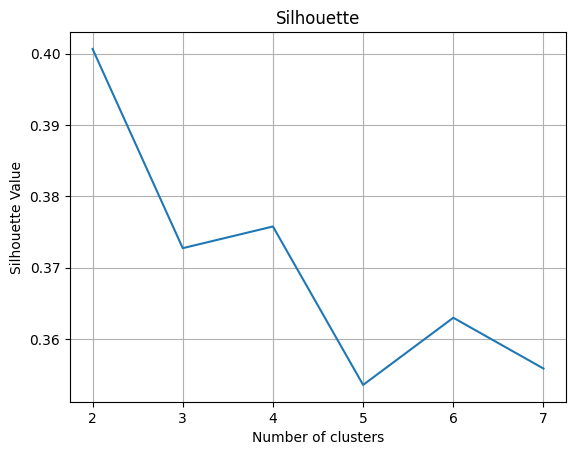

In [ ]:
np.random.seed(0)
sil = []
best_num_cluster = 12
for i in range(2,8):
  kclusterer = KMeans(n_clusters=i,n_init=3)
  assigned_clusters = kclusterer.fit_predict(df_clustering)
  sil.append(metrics.silhouette_score(df_clustering, assigned_clusters))

best_num_cluster = sil.index(min(sil))+2

fig = plt.figure()
ax = fig.add_subplot()
plt.plot(range(2,8), sil)
ax.set_ylabel('Silhouette Value')
ax.set_xlabel('Number of clusters')
plt.grid()
plt.title('Silhouette')
plt.show()

In [ ]:
np.random.seed(0)
num_clusters = best_num_cluster
pca = PCA(n_components=2)

df_clustering = pca.fit_transform(df_clustering)
kmeans = KMeans(n_clusters=num_clusters,n_init=3)
cluster_assignments = kmeans.fit_predict(df_clustering)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

In [ ]:
# --- merged dataframe for the plot ---

# clusters
value_cluster = pd.DataFrame()
value_cluster['PCA Component 1'] = df_clustering[:, 0]
value_cluster['PCA Component 2'] = df_clustering[:, 1]
value_cluster['Cluster num.'] = cluster_assignments.astype(str)
value_cluster['Cluster num.'] = 'Cluster ' + value_cluster['Cluster num.']
value_cluster['Country/Territory'] = df_mean['Country/Territory']
value_cluster = value_cluster.sort_values(by = 'Cluster num.' )

# centers
centers_coord = pd.DataFrame()
centers_coord['x'] = centers[:, 0]
centers_coord['y'] = centers[:, 1]
centers_coord['Cluster'] = range(0,best_num_cluster,1)
centers_coord['Cluster'] = centers_coord['Cluster'].astype(str)

In [ ]:
# points
fig = px.scatter(value_cluster,
                 x = "PCA Component 1",
                 y = "PCA Component 2",
                 color = 'Cluster num.',
                 title="Countries clusters with K-Means and PCA",
                 hover_name='Country/Territory'
)
# points appearance
fig.update_traces(marker=dict(size=12,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

# cluster centers
fig.add_trace(go.Scatter(x=centers_coord['x'],
                         y=centers_coord['y'],
                         text = centers_coord['Cluster'],
                         name = '',
                         hovertemplate =
                                "<br><b>Center for cluster %{text}</b><br> " +
                                "<br><b>Coord. 1</b>: %{x}<br>" +
                                 "<b>Coord. 2</b>: %{y}<br>",
                         mode='markers',
                         marker=dict(color='black',
                                      size=12),
                         showlegend=False))
# centers circle
fig.add_trace(go.Scatter(x=centers_coord['x'],
                         y=centers_coord['y'],
                         name = '',
                         mode='markers',
                         hoverinfo='none',
                         hovertemplate = '',
                        marker=dict(size=100,
                                    color='rgba(0,0,0,0)',
                                    line=dict(color='black',
                                              width=2)),
                        showlegend=False))
# figure layout
fig.update_layout(
    plot_bgcolor='white',
    title=dict(font=dict(size=20,
                         color="black")),
    legend=dict(title="Cluster num.",
                font=dict(
                      #family="Consolas",
                      size=14,
                      color="black"
    )),
    legend_tracegroupgap=10
)
# axes
fig.update_xaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey',
    zeroline=False
)
fig.update_yaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey',
    zeroline=False
)

fig.show()

In [ ]:
df_mean["Cluster"] = cluster_assignments
df_freedom = df_freedom.set_index("Country/Territory").join(df_mean[["Country/Territory", "Cluster"]].set_index("Country/Territory"), on="Country/Territory", how='left').reset_index()

In [ ]:
# ----- Radar chart for clusters -----

df_cluster=pd.DataFrame()
for column in columns_for_cluster:
  df_group = df_mean.groupby("Cluster")[column].agg(["mean", "std"])
  mean_col = f"mean_{column.lower()}"  # Create a dynamic column name
  std_col = f"sd_{column.lower()}"      # Create a dynamic column name
  df_group = df_group.rename(columns={"mean": mean_col, "std": std_col})
  df_group=df_group.round(3)
  df_cluster=pd.concat([df_cluster,df_group],axis=1)


# take only the mean values
df_cluster_mean = df_cluster[df_cluster.columns[pd.Series(df_cluster.columns).str.startswith('mean')]]

# catagories
categories = df_cluster_mean.columns
# categories=categories.drop(['Media_gdp','Media_population'])
fig = go.Figure()

for i in range(best_num_cluster):

  fig.add_trace(go.Scatterpolar(
        r = df_cluster_mean.iloc[i].values,
        theta=categories,
        fill='toself',
        name=f'Cluster {i}'
  ))

fig.update_layout(title = dict(text = "<b>Radar chart on clusters features</b>",
                               x=0.5,
                               xref="paper",
                               font=dict(size=20, color="black")))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
  showlegend=True
)

fig.show()

In [ ]:
df_world

Total    Population        GDP  Life Index  \
Region Edition                                               
World  2006     0.551  6.463309e+09  11009.598       0.417   
       2007     0.548  6.550544e+09  11772.385       0.417   
       2008     0.542  6.633037e+09  12316.386       0.418   
       2009     0.543  6.714612e+09  12272.177       0.417   
       2010     0.542  6.795971e+09  12920.156       0.416   
       2011     0.541  6.881191e+09  13608.979       0.420   
       2012     0.542  6.977343e+09  14126.912       0.425   
       2013     0.539  7.078655e+09  14600.216       0.423   
       2014     0.539  7.166908e+09  14956.306       0.428   
       2015     0.535  7.253672e+09  15092.592       0.425   
       2016     0.531  7.328483e+09  15545.702       0.426   
       2017     0.524  7.410753e+09  16187.500       0.428   
       2018     0.517  7.494072e+09  16992.181       0.425   
       2019     0.503  7.574007e+09  17648.827       0.424   
       2020     0.492  7.644723e+09  17238.552       0.414   
       2021     0.476  7.710770e+09  18797.383       0.407   

                Political Stability  Birth rate  Life expectancy  
Region Edition                                                    
World  2006                  -0.642      20.366           69.552  
       2007                  -0.664      20.314           69.821  
       2008                  -0.649      20.247           69.998  
       2009                  -0.696      20.070           70.396  
       2010                  -0.734      19.917           70.670  
       2011                  -0.713      20.040           71.015  
       2012                  -0.680      20.188           71.289  
       2013                  -0.690      19.736           71.557  
       2014                  -0.626      19.657           71.868  
       2015                  -0.645      19.123           72.085  
       2016                  -0.650      19.169           72.367  
       2017                  -0.572      18.702           72.558  
       2018                  -0.613      18.179           72.803  
       2019                  -0.571      17.816           72.995  
       2020                  -0.584      17.213           72.251  
       2021                  -0.586      16.924           71.328

<ipython-input-27-573386428c44>:2: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



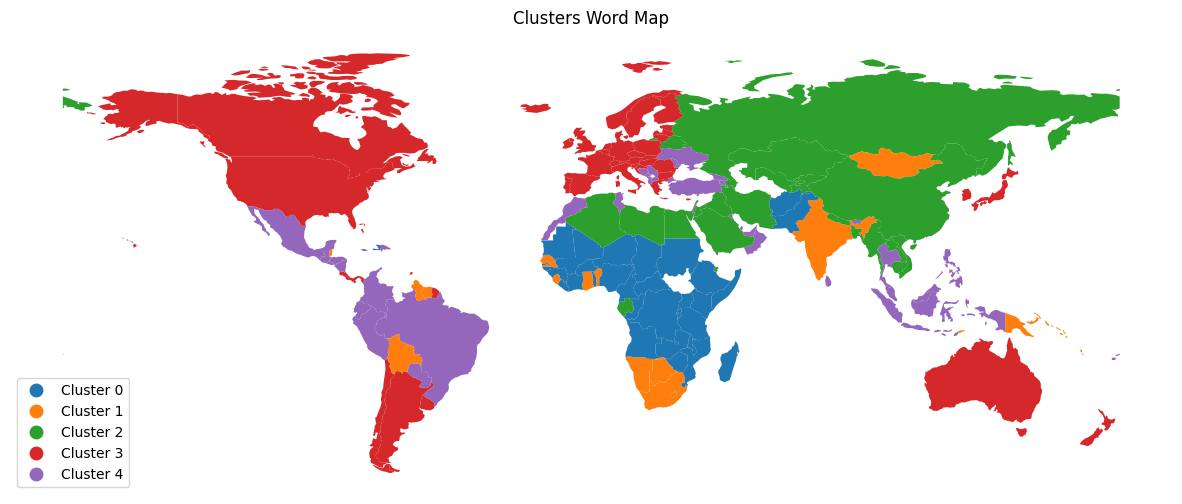

In [ ]:
df = df_freedom[df_freedom["Edition"] == 2021][["Region", "Country Code", "Life Index", "Cluster"]]
df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
df_world = df_world.merge(df, how="left", left_on=['iso_a3'], right_on=['Country Code'])
df_world = df_world.dropna()
df_world['Cluster'] = df_world['Cluster'].astype(int)
df_world['Cluster'] = df_world['Cluster'].astype(str)
df_world['Cluster'] = 'Cluster ' + df_world['Cluster']

custom_cmap = plt_colors.LinearSegmentedColormap.from_list(
    "custom_cmap", ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
)

df_world.plot(column="Cluster", cmap=custom_cmap, legend=True,
              legend_kwds={"loc": "lower left"}, figsize=(15, 17))
plt.title('Clusters Word Map')
plt.axis('off')
plt.show()

In [ ]:
# ----- Denormalized Cluster Values -----

df_cluster["mean_gdp"] = np.round(min_max_scaler_gdp.inverse_transform(df_cluster[["mean_gdp_norm"]]))
df_cluster["mean_political_stability"] = df_cluster[["mean_political_stability_norm"]]
df_cluster["mean_birth_rate"] = np.round(min_max_scaler_birth.inverse_transform(df_cluster[["mean_birth_rate_norm"]]))
df_cluster["mean_life_expentancy"] = np.round(min_max_scaler_life.inverse_transform(df_cluster[["mean_life_expentancy_norm"]]))
df_cluster[["mean_birth_rate", "mean_gdp", "mean_life_expentancy", "mean_political_stability", "mean_total"]]

,mean_birth_rate,mean_gdp,mean_life_expentancy,mean_political_stability,mean_total
Cluster,,,,,
0,38.0,3132.0,59.0,0.406,0.365
1,28.0,6060.0,65.0,0.706,0.781
2,22.0,13219.0,71.0,0.457,0.247
3,12.0,34857.0,78.0,0.805,0.912
4,17.0,20540.0,74.0,0.584,0.559


## **Relation between `Life Index` and Clusters**

---

Since `Value` is a synthesis of all the columns we used for computing the `cluster` column, we can use it for  .

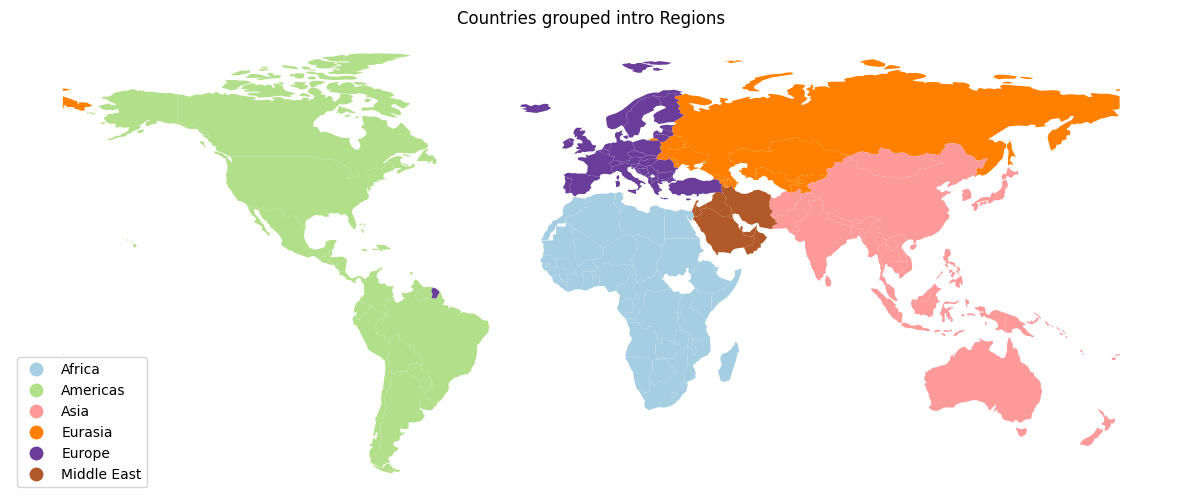

In [ ]:
df_world.plot(column="Region", cmap='Paired', legend=True,
              legend_kwds={"loc": "lower left"}, figsize=(15, 17))
plt.title('Countries grouped intro Regions')
plt.axis('off')
plt.show()

In [ ]:
# -- clusters, regions and mean Value --
country_regions = df_freedom.groupby(['Country/Territory', 'Region'], as_index = False).size()
clusters_regions = pd.merge(df_mean, country_regions.loc[:, ['Country/Territory', 'Region']], on = 'Country/Territory')
clusters_regions = clusters_regions.drop(['Edition'], axis = 1)
# fromclusters_regions

In [ ]:
# --- how many countries per region in each cluster ---
new = clusters_regions.groupby(['Region', 'Cluster'], as_index = False)['Country/Territory'].count()
new['color'] = new['Region']
new = new.replace({"color":{"Eurasia": "blue", "Asia": "orange", "Middle East": "green", "Africa": "red", "Americas":"purple","Europe": "brown"}})
new

,Region,Cluster,Country/Territory,color
0,Africa,0,34,red
1,Africa,1,9,red
2,Africa,2,5,red
3,Africa,3,2,red
4,Africa,4,3,red
5,Americas,0,1,purple
6,Americas,1,4,purple
7,Americas,3,17,purple
8,Americas,4,12,purple
9,Asia,0,2,orange


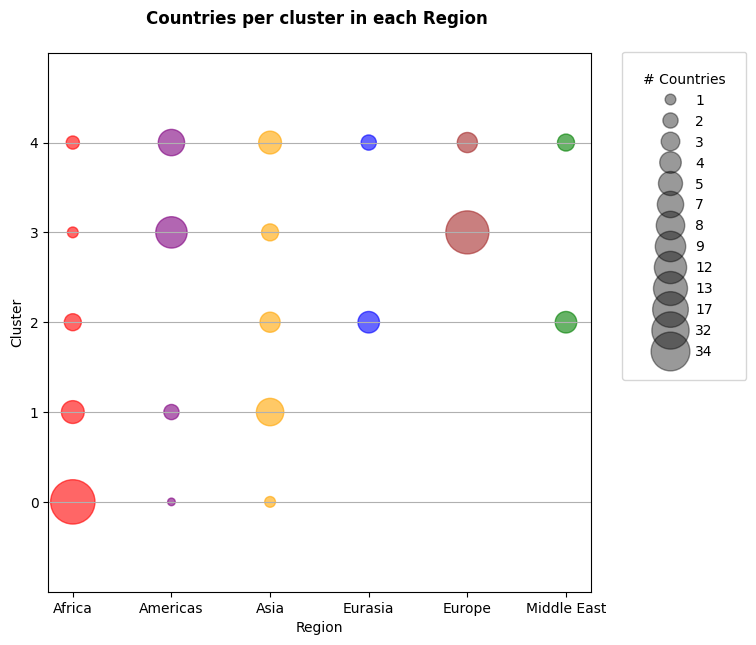

In [ ]:
fig, ax = plt.subplots(figsize = (7, 7))
sc = ax.scatter(x=new["Region"], y=new['Cluster'], c = new['color'], s = new['Country/Territory']*30, alpha=0.6)
ax.set_title('Countries per cluster in each Region \n', fontweight = 'bold')
ax.set_xlabel('Region')
ax.set_ylabel('Cluster')
ax.set_yticks(np.arange(0, best_num_cluster, step=1))
ax.set_ylim(-1, best_num_cluster)
plt.grid(axis = 'y')
hand, lab = sc.legend_elements(prop="sizes", alpha=0.4, num=15)
ax.legend(hand, np.sort(new['Country/Territory'].unique()), loc="upper right", title="# Countries", bbox_to_anchor=(1.30, 1.015), ncol=1, borderpad=1.5)
fig.show()

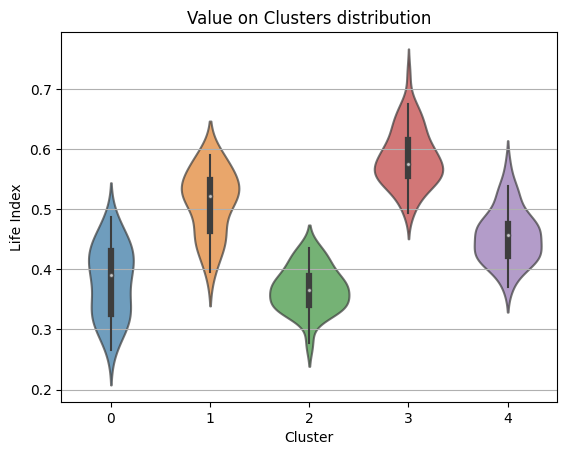

In [ ]:
# comments: which are the more populous clusters, which has the widest range, ...

ax = sns.violinplot(data=clusters_regions.loc[:, ['Life Index', 'Cluster']], y="Life Index", x="Cluster")
plt.setp(ax.collections, alpha=.7)
plt.grid(axis = 'y')
plt.xlabel('Cluster')
plt.title('Value on Clusters distribution')
plt.show()

## **ARIMA on regional `Life Index`**

In [ ]:
# -- Agregate by Region --

FIW_0323 = {}
for region in regions:
  FIW_0323[region] = df_freedom.groupby(by=['Region','Edition'], as_index = False)['Life Index'].mean()
  FIW_0323[region] = FIW_0323[region][FIW_0323[region]['Region'] == region][['Edition', 'Life Index']]
  FIW_0323[region] = FIW_0323[region].set_index('Edition')

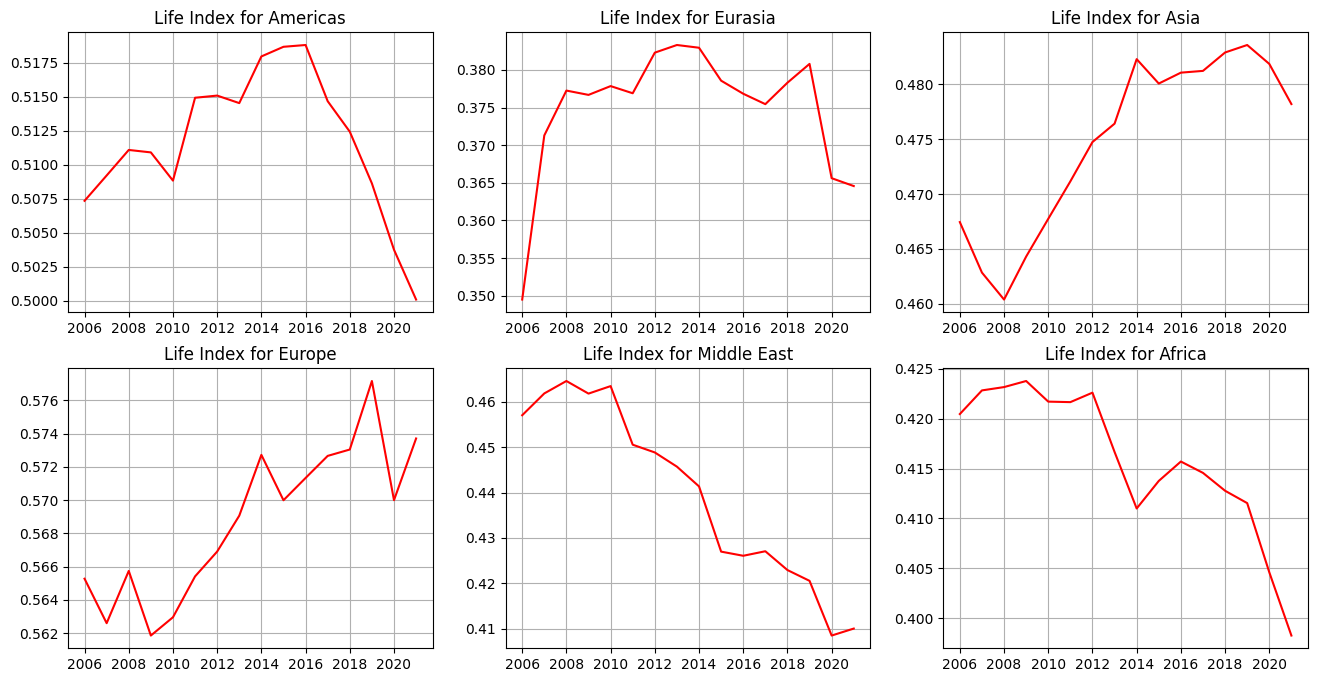

In [ ]:
fig, plts = plt.subplots(2,3, figsize=(16, 8))
for i in range(len(regions)):
  plts[0 if i < 3 else 1, i if i < 3 else i-3].plot(FIW_0323[regions[i]]["Life Index"], color = 'red')
  plts[0 if i < 3 else 1, i if i < 3 else i-3].set_title(f'Life Index for {regions[i]}')
  plts[0 if i < 3 else 1, i if i < 3 else i-3].grid()
  # set years as integers on the x axis
  plts[0 if i < 3 else 1, i if i < 3 else i-3].xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()


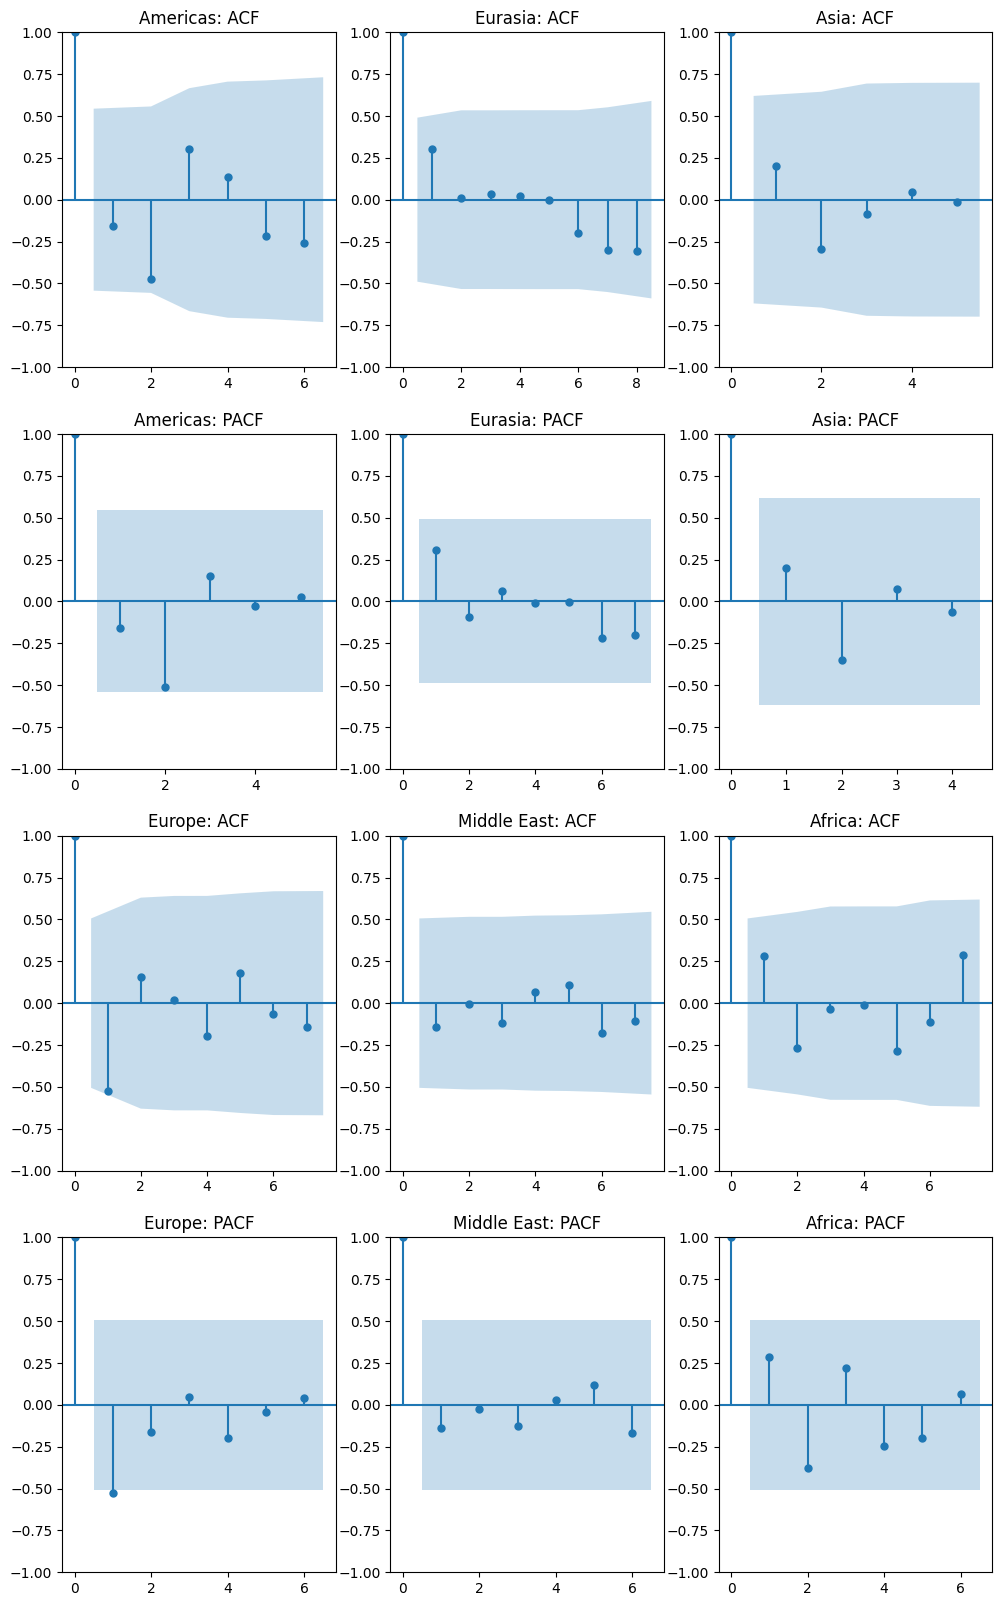

In [ ]:
# If the time serie is non-stationary, we need to perform differencing and then repeat the Dickey-Fuller test to check untill it is stationary
def check_and_difference(data, max_differences=3, alpha=0.05):
    """
    Perform Dickey-Fuller test and differencing to achieve stationarity.

    Parameters:
        data (pd.Series): The time series data to be checked and differenced.
        max_differences (int): Maximum number of differencing steps to perform.
        alpha (float): Significance level for the Dickey-Fuller test.

    Returns:
        differenced_data (pd.Series): Differenced data (if necessary).
        num_differences (int): Number of differencing steps performed.
    """
    def perform_differencing(data, num_differences):
        return data.diff(num_differences).dropna()

    p_value = adfuller(data)[1]

    if p_value <= alpha:
        stat = f'The time serie is stationary, p-value =  {p_value}'
        num_differences = 0
        differenced_data = data
    else:
        stat = f'The time serie is non-stationary, p-value =  {p_value}'
        num_differences = 1
        differenced_data = perform_differencing(data, num_differences)

        while num_differences < max_differences:
            p_value = adfuller(differenced_data)[1]
            if p_value <= alpha:
                break
            num_differences += 1
            differenced_data = perform_differencing(differenced_data, num_differences)

    return differenced_data, num_differences, stat

num_differences = {}
differenced_data = {}
for region in regions:
  differenced_data_region, num_differences_region, stat = check_and_difference(FIW_0323[region])
  num_differences[region] = num_differences_region
  differenced_data[region] = differenced_data_region
  #print(stat)
  #print("Number of differencing steps performed:", num_differences)
  #print('Differenced data:')
  #plt.plot(differenced_data, color = 'green')
  #plt.grid()
  #plt.show()

fig, axs = plt.subplots(4, 3, figsize=(12, 20))
for i in range(len(regions)):
    plot_acf(differenced_data[regions[i]], ax=axs[0 if i < 3 else 2, i if i < 3 else i-3], lags= (len(differenced_data[regions[i]])/2), title=f'{regions[i]}: ACF')
    plot_pacf(differenced_data[regions[i]], ax=axs[1 if i < 3 else 3, i if i < 3 else i-3], lags=(len(differenced_data[regions[i]])/2)-1, title=f'{regions[i]}: PACF')
plt.show()

In [ ]:
forecast_values = {}
conf_int = {}
param_arima = {}

for region in regions:
  # Use auto_arima to automatically find the best parameters
  model = auto_arima(FIW_0323[region], seasonal=False, trace=False, suppress_warnings=True,
                    start_p=0, start_q=0, d=num_differences[region], max_p=5, max_q=5)

  #print("{} Best ARIMA parameters: (p={}, d={}, q={})".format(region, model.order[0], model.order[1], model.order[2]))

  key = region
  value = model.order
  param_arima[key] = value

  # Fit the ARIMA model on differenced data
  model = ARIMA(FIW_0323[region], order=model.order)
  results = model.fit()

  # Number of steps for forecasting
  forecast_steps = 5

  # Generate forecasts on the differenced data
  forecast = results.get_forecast(steps=forecast_steps)
  #forecast_values[]
  forecast_values[region] = round(forecast.predicted_mean,2)
  forecast_values[region].index = range(2022, 2022+forecast_steps, 1)
  conf_int[region] = forecast.conf_int(alpha=0.05)
  conf_int[region].index = range(2022, 2022+forecast_steps, 1)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is

In [ ]:
arima_params = pd.DataFrame.from_dict(param_arima, orient='index')
arima_params.rename(columns = {0:'p', 1:'d',2:'q'}, inplace = True)
arima_params

,p,d,q
Americas,0,2,1
Eurasia,1,0,0
Asia,1,3,0
Europe,1,1,0
Middle East,0,1,0
Africa,0,1,1


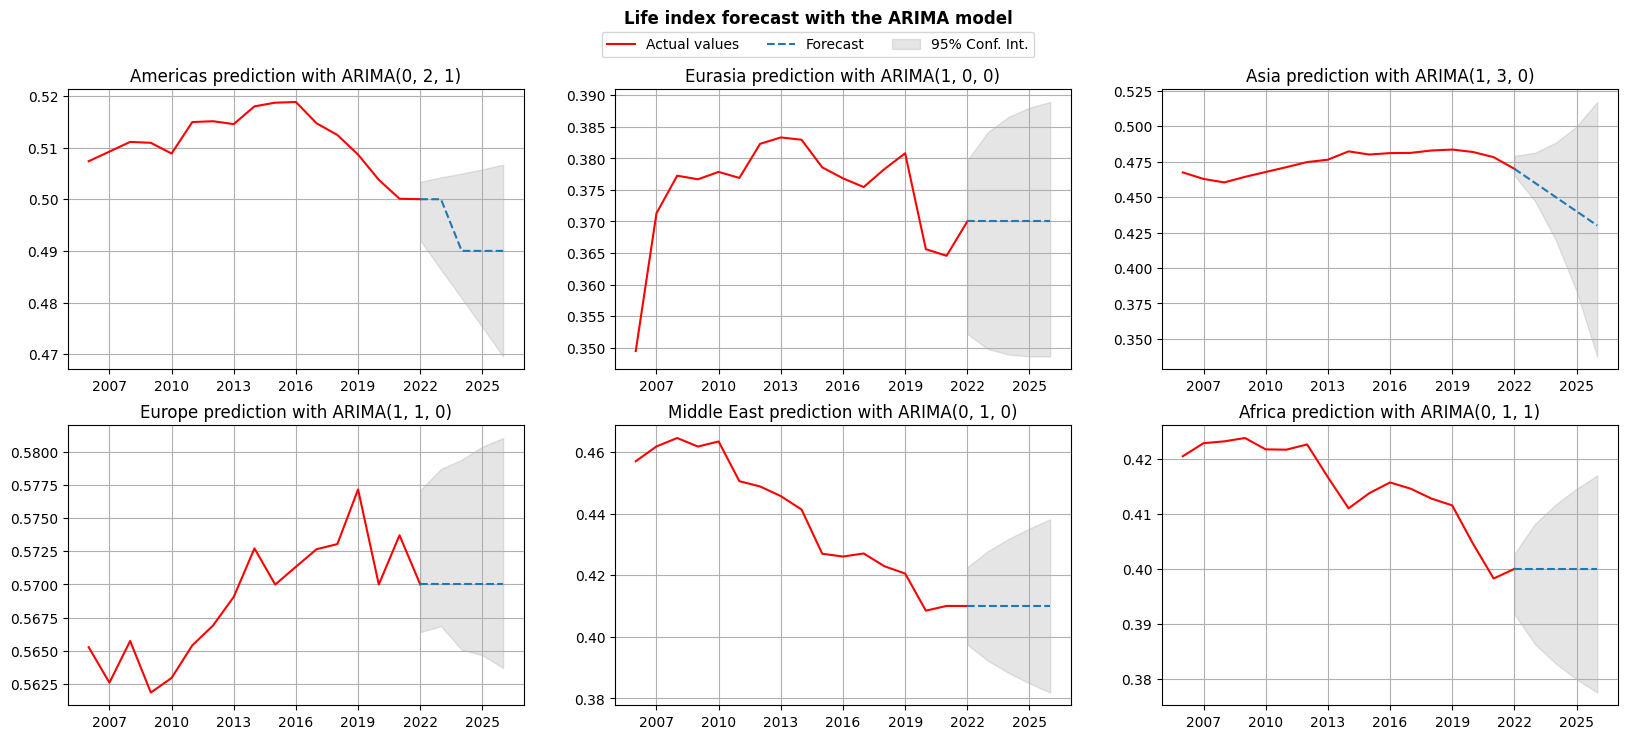

In [ ]:
fig, plts = plt.subplots(2,3, figsize=(20, 8))
for i in range(len(regions)):
  sub_plot = plts[0 if i < 3 else 1, i if i < 3 else i-3]
  sub_plot.plot(pd.concat([FIW_0323[regions[i]]["Life Index"], forecast_values[regions[i]].iloc[:1]]), label='Actual values', color = 'red')
  sub_plot.plot(forecast_values[regions[i]], label='Forecast', ls = '--')
  sub_plot.fill_between(conf_int[regions[i]].index, conf_int[regions[i]].iloc[:, 0], conf_int[regions[i]].iloc[:, 1], color='gray', alpha=0.2, label='95% Conf. Int.')
  sub_plot.set_title(f'{regions[i]} prediction with ARIMA{list(param_arima.values())[i]}')
  sub_plot.grid()
  sub_plot.xaxis.set_major_locator(MaxNLocator(integer=True))
  handles, labels = sub_plot.get_legend_handles_labels()
fig.suptitle("Life index forecast with the ARIMA model", fontweight = 'bold')
fig.legend(handles, labels,  loc='upper center', bbox_to_anchor=(0.5, 0.96), ncol = 3)
plt.show()

## **ARIMA on single Country features**

---


In [ ]:
# countries list
countries = df_freedom['Country/Territory'].unique()

In [ ]:
# columns list
col = [
    "GDP",
    "Total",
    "Political Stability",
    "Birth rate",
    "Life expectancy"]

In [ ]:
col

['GDP', 'Total', 'Political Stability', 'Birth rate', 'Life expectancy']

In [ ]:
countries_dict = {}
k = 0
for i in countries:
  key = i
  value = df_freedom[df_freedom['Country/Territory'] == i].sort_values(by =['Edition'], ascending = True)
  countries_dict[key] = value
  #FIW_0323[region] = FIW_0323[region].set_index('Edition')

In [ ]:
df_2026 = pd.DataFrame(columns =  ["GDP",
    "Total",
    "Political Stability",
    "Birth rate",
    "Life expectancy"])

In [ ]:
country = 'Italy'
countries_dict[country][['Edition',	'Total',	'Population',	'GDP', 'Political Stability',	'Birth rate',	'Life expectancy', 'Life Index']].round(3)

,Edition,Total,Population,GDP,Political Stability,Birth rate,Life expectancy,Life Index
2843,2006,0.92,58143979.0,32451.493,0.531,9.6,81.283,0.578
2662,2007,0.92,58438310.0,34145.546,0.447,9.7,81.434,0.577
2480,2008,0.92,58826731.0,35523.271,0.548,9.8,81.485,0.584
2298,2009,0.90,59095365.0,34603.256,0.347,9.6,81.637,0.570
2116,2010,0.89,59277417.0,35156.668,0.474,9.5,82.037,0.576
1934,2011,0.89,59379449.0,36598.015,0.501,9.2,82.188,0.578
1749,2012,0.89,59539717.0,36486.297,0.508,9.0,82.239,0.578
1563,2013,0.88,60233948.0,36314.697,0.495,8.5,82.690,0.575
1376,2014,0.90,60789140.0,36194.874,0.458,8.3,83.090,0.578
1189,2015,0.89,60730582.0,36899.385,0.376,8.0,82.544,0.569


In [ ]:
param_arima_country = {}
for j in col:

  differenced_data, num_differences, stat = check_and_difference(countries_dict[country][j])

  model = auto_arima(countries_dict[country][j], seasonal=True, trace=False, suppress_warnings=True,
                    start_p=0, start_q=0,  d=num_differences, max_p=5, max_q=5)

  key = j
  value = model.order
  param_arima_country[key] = value

  best_p, best_d, best_q = model.order
  model = ARIMA(countries_dict[country][j], order=(best_p, best_d, best_q))
  results = model.fit()

  # Number of steps for forecasting: 5 "new years"
  forecast_steps = 5

  # Generate forecasts
  forecast = results.get_forecast(steps=forecast_steps)
  forecast_values = forecast.predicted_mean

  if j == 'GDP':
    GDP = forecast_values.iloc[-1]
  elif j == 'Total':
    Total = forecast_values.iloc[-1]
  elif j == 'Political Stability':
    Political_Stability = forecast_values.iloc[-1]
  elif j == 'Birth rate':
    Birth = forecast_values.iloc[-1]
  elif j == 'Life expectancy':
    Life = forecast_values.iloc[-1]

row = {'Country/Territory': [country], 'Edition': ['2026'], 'GDP' : [GDP],	'Total' : [Total],	'Political Stability' : [Political_Stability],
        'Birth rate' : [Birth], 'Life expectancy' : [Life]}

row = pd.DataFrame(row)
df_2026 = pd.concat([df_2026, row], axis = 0)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/usr/local/lib/python3.10/dist-packages/sta

In [ ]:
param_arima_country = pd.DataFrame.from_dict(param_arima_country, orient='index')
param_arima_country.rename(columns = {0:'p', 1:'d',2:'q'}, inplace = True)
param_arima_country

,p,d,q
GDP,0,1,0
Total,1,0,0
Political Stability,0,0,0
Birth rate,1,3,0
Life expectancy,1,1,0


In [ ]:
df_2026

,GDP,Total,Political Stability,Birth rate,Life expectancy,Country/Territory,Edition
0,46705.017906,0.900389,0.44468,8.98749,82.615697,Italy,2026


In [ ]:
# Life index recomputing: nomalization + sum

df_2026['GDP_norm'] = min_max_scaler_gdp.transform(df_2026[['GDP']])
df_2026['Total'] = df_2026['Total']/100

df_2026['Political_stability_norm'] = min_max_scaler_pol.transform(df_2026[['Political Stability']])

df_2026['Birth_rate_norm'] = min_max_scaler_birth.transform(df_2026[['Birth rate']])

df_2026['Life_expentancy_norm'] = min_max_scaler_life.transform(df_2026[['Life expectancy']])

df_2026['Life Index'] = (df_2026['GDP_norm'] + df_2026['Total'] + df_2026['Political_stability_norm'] + df_2026['Birth_rate_norm'] + df_2026['Life_expentancy_norm'])/5

df_2026

,GDP,Total,Political Stability,Birth rate,Life expectancy,Country/Territory,Edition,GDP_norm,Political_stability_norm,Birth_rate_norm,Life_expentancy_norm,Life Index
0,46705.017906,0.009004,0.44468,8.98749,82.615697,Italy,2026,0.283828,0.73249,0.086396,0.953314,0.413006
